# Data Exploration

Exploring the use of data transformation methods to extract dominant colours from an image

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 25/11/2025   | Martin | Created   | Exploring colour quantisation | 
| 30/12/2025   | Martin | Update   | Added some new methods: manual edges and superpixel grouping | 

# Content

* [Introduction](#introduction)
* [Finding Dominant Colours](#finding-dominant-colours)
* [Method 1: Finding Contours](#method-1-finding-contours)

# Finding Dominant Colours

<u>Application Notes</u>

1. Specify the image channel (e.g RGB, BGR, HSV, ...)
2. Resize the image

In [1]:
%load_ext watermark

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
img = cv2.imread("data/img1.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
# Use KMeans clustering to find most common colours
def dominant_colours(img_path, k=10):
  img = cv2.imread(f"data/{img_path}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Flatten the image
  pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Reconstructs the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))
  
  return img, quantised_img, d_colours

In [4]:
K = 10
IMG_PATH = 'img5.jpg'
original_img, quantised_img, d_colours = dominant_colours(IMG_PATH, k=K)

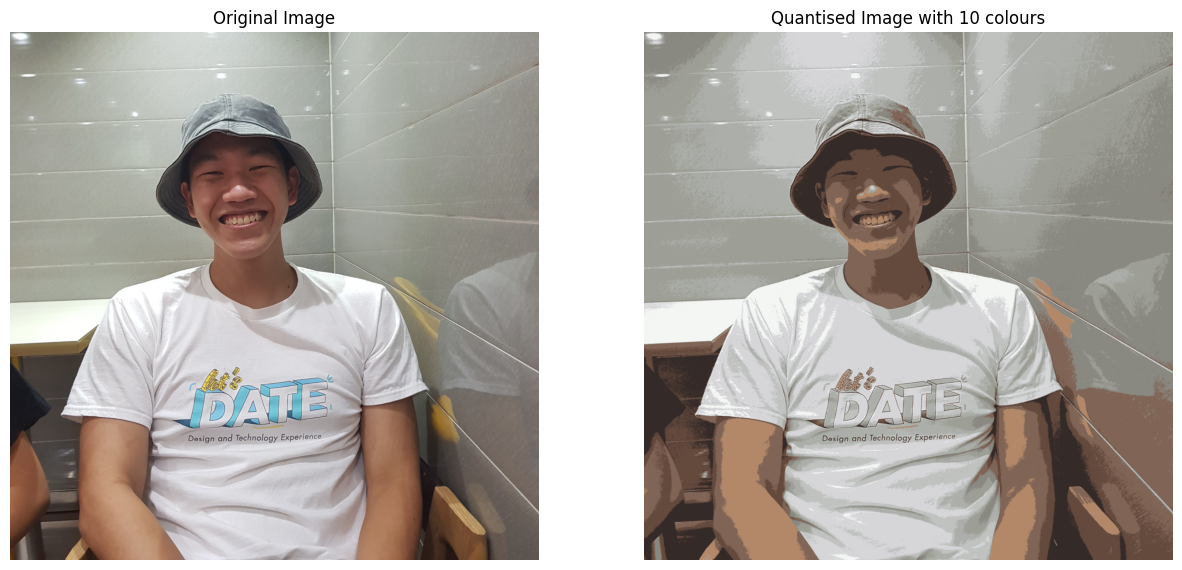

In [5]:
# Display results
plt.figure(figsize=(15, 12))

# Plot the original image
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(original_img)

# Plot the quantised image
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f'Quantised Image with {K} colours')
plt.imshow(quantised_img)

print()

plt.show()

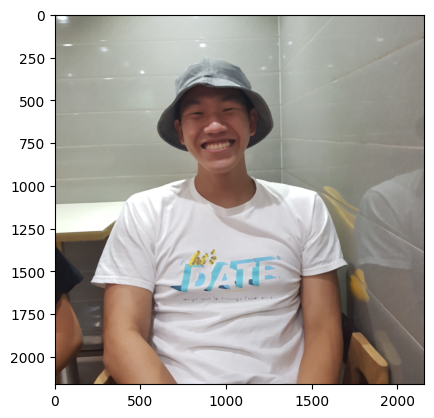

In [11]:
smoothed = cv2.bilateralFilter(original_img, d=9, sigmaColor=75, sigmaSpace=75)
cleaned = cv2.medianBlur(original_img, 11)
plt.imshow(cleaned)

# Method 1: Finding Contours

In [24]:
def generate_paint_by_numbers(img_path, k=10, min_area_threshold=200, source_encoding="RGB"):
  img = cv2.imread(img_path)

  if source_encoding == "BGR":
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # img = cv2.medianBlur(img, 7)
  shifted = cv2.pyrMeanShiftFiltering(img, sp=21, sr=51)

  # Flatten the image
  pixel_list = img.reshape((shifted.shape[0] * shifted.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Recreate the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))

  # Create the PBN image
  labels_grid = labels.reshape(img.shape[:2])
  canvas = np.ones((img.shape[0], img.shape[1], 3), dtype='uint8') * 255

  for colour_id in range(K):
    # Binary mask - 255 if matches, 0 if not
    mask = np.where(labels_grid == colour_id, 255, 0).astype('uint8')

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      # Filters out smaller areas
      if cv2.contourArea(contour) > min_area_threshold:
        # Draw the contours on the canvas
        cv2.drawContours(canvas, [contour], -1, (100, 100, 100), 1)

        # Find the center region for each cluster for each colour
        M = cv2.moments(contour)
        if M["m00"] != 0:
          center_X = int(M["m10"] / M["m00"])
          center_Y = int(M["m01"] / M["m00"])

          # Put label in the area
          cv2.putText(
            canvas,
            str(colour_id),
            (center_X, center_Y),
            cv2.FONT_HERSHEY_COMPLEX,
            0.8,
            (0, 0, 0),
            1
          )
  
  # Plot the entire image
  plt.figure(figsize=(20, 15))

  # Original Image
  plt.subplot(2, 2, 1)
  plt.axis('off')
  plt.title("Original Image")
  plt.imshow(img)

  # Original Image
  plt.subplot(2, 2, 2)
  plt.axis('off')
  plt.title("Quantised Image")
  plt.imshow(quantised_img)

  # PBN Image
  plt.subplot(2, 2, 3)
  plt.axis('off')
  plt.title("Paint By The Numbers")
  plt.imshow(canvas)

  # Colour palette
  plt.subplot(2, 2, 4)
  legend_height = 50 * k
  legend_img = np.zeros((legend_height, 200, 3), dtype='uint8') + 255

  for i, colour in enumerate(d_colours):
    cv2.rectangle(legend_img, (10, i*50+10), (60, i*50 + 40), colour.tolist(), -1)
    cv2.putText(
      legend_img,
      f"ID {i}",
      (70, i*50 + 35),
      cv2.FONT_HERSHEY_SIMPLEX, 
      0.5,
      (0, 0, 0),
      1
    )
  plt.imshow(legend_img)
  plt.show()

  return img, quantised_img, canvas

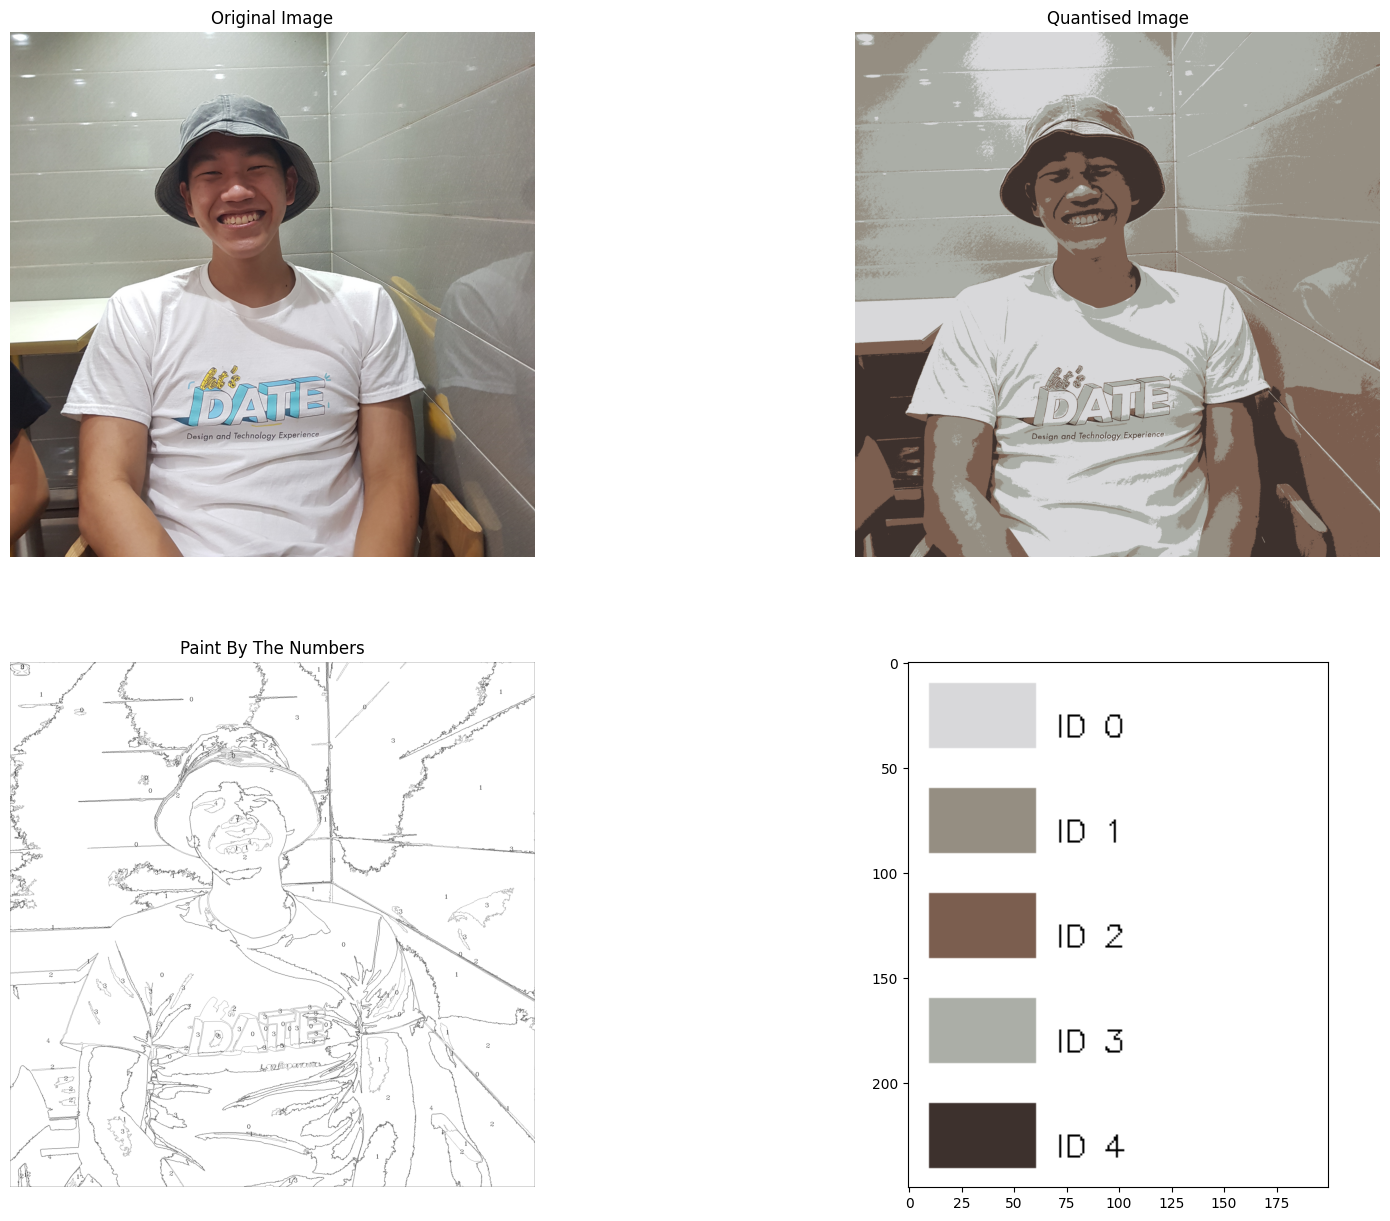

In [29]:
IMG_PATH = "data/img5.jpg"
K = 5

original_img, quantised_img, canvas = generate_paint_by_numbers(
  IMG_PATH,
  k=K,
  min_area_threshold=500,
  source_encoding="BGR"
)

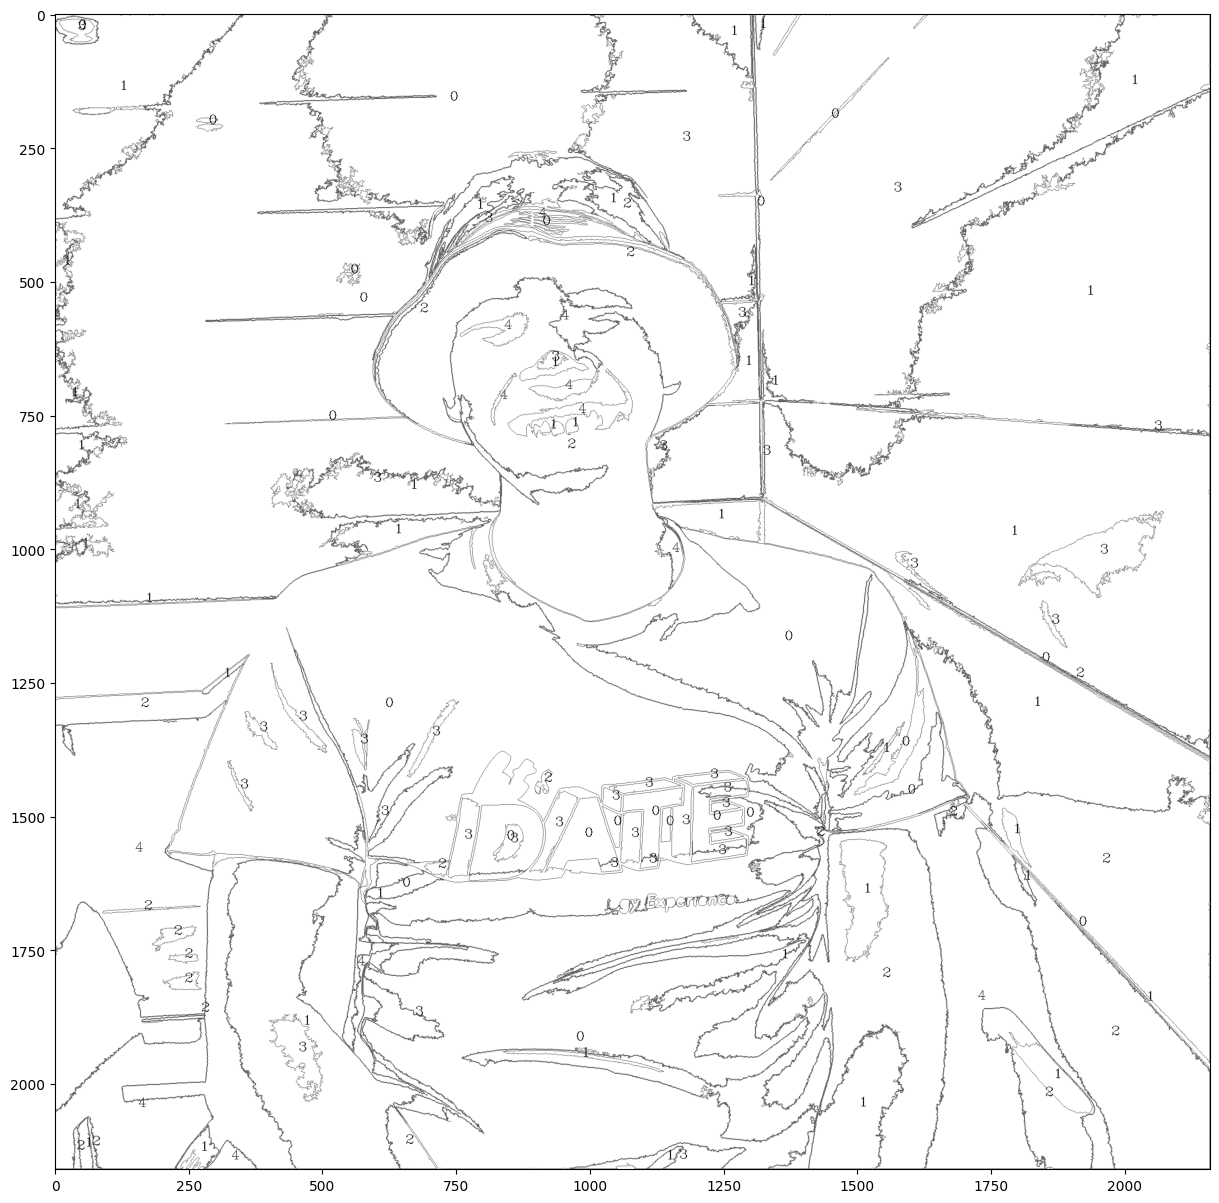

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(canvas)

# Method 2: Manually Finding Edges

Moving horizontally and vertically, change the pixel value to black if the colour changes

In [16]:
def manual_edges(img):
  # Create a mask of black pixels
  pbn = np.zeros([img.shape[0], img.shape[1]])
  black = np.full([img.shape[0], img.shape[1]], np.array([0, 0, 0]))

  # Horizontal move 
  prev_pixel = img[0][0]
  for j in range(img.shape[1]):
    for i in range(img.shape[0]):
      current_pixel = img[i][j]
      if not np.array_equal(prev_pixel, current_pixel):
        pbn[i][j] = 1
      
      prev_pixel = current_pixel

  # Vertical move
  prev_pixel = img[0][0]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      current_pixel = img[i][j]
      if not np.array_equal(prev_pixel, current_pixel):
        pbn[i][j] = 1
      
      prev_pixel = current_pixel
  
  pbn = pbn * black
  
  return pbn

In [17]:
manual_edges(sp_quant)

ValueError: could not broadcast input array from shape (3,) into shape (360,640)

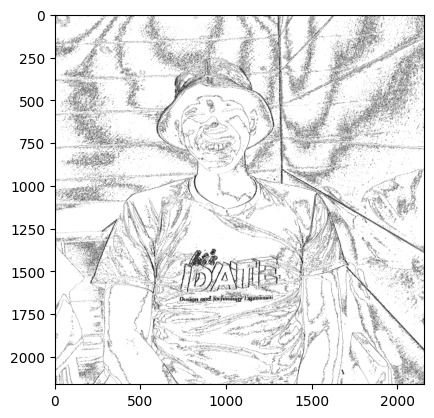

In [22]:
plt.imshow(pbn)

# Method 3: Superpixel Segmentation

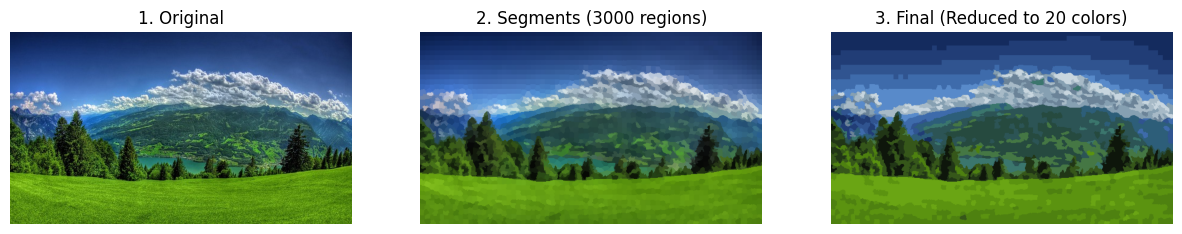

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import label2rgb

def process_with_superpixels(image_path, n_segments=500, k_colors=10):
  # 1. Load Image
  img = cv2.imread(image_path)
  if img is None: return
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # 2. Generate Superpixels (The "Edge First" Step)
  # n_segments: Approximate number of "puzzle pieces" you want
  # compactness: Higher = more square/regular shapes. Lower = more adherence to weird edges.
  # sigma: Smooths the image slightly before cutting segments
  segments = slic(img, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
  
  # 3. Calculate Average Color for Each Segment
  # We create a new image where every pixel in a segment is replaced by that segment's average color
  superpixel_img = label2rgb(segments, img, kind='avg')
  
  # 4. Quantize to k_colors (The "Fill Color" Step)
  # Now we run K-Means on the *superpixel* image, not the raw noisy image
  flat_img = superpixel_img.reshape((-1, 3))
  clt = KMeans(n_clusters=k_colors, n_init='auto')
  clt.fit(flat_img)
  
  # Reconstruct
  labels = clt.labels_
  centers = clt.cluster_centers_.astype("uint8")
  quantized_img = centers[labels].reshape(img.shape)
  
  # 5. Display
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 3, 1)
  plt.title("1. Original")
  plt.axis('off')
  plt.imshow(img)
  
  plt.subplot(1, 3, 2)
  plt.title(f"2. Segments ({n_segments} regions)")
  plt.axis('off')
  plt.imshow(superpixel_img)
  
  plt.subplot(1, 3, 3)
  plt.title(f"3. Final (Reduced to {k_colors} colors)")
  plt.axis('off')
  plt.imshow(quantized_img)
  
  plt.show()

  return superpixel_img, quantized_img

# Run it
superpixel, sp_quant = process_with_superpixels('data/img1.jpg', n_segments=3000, k_colors=20)

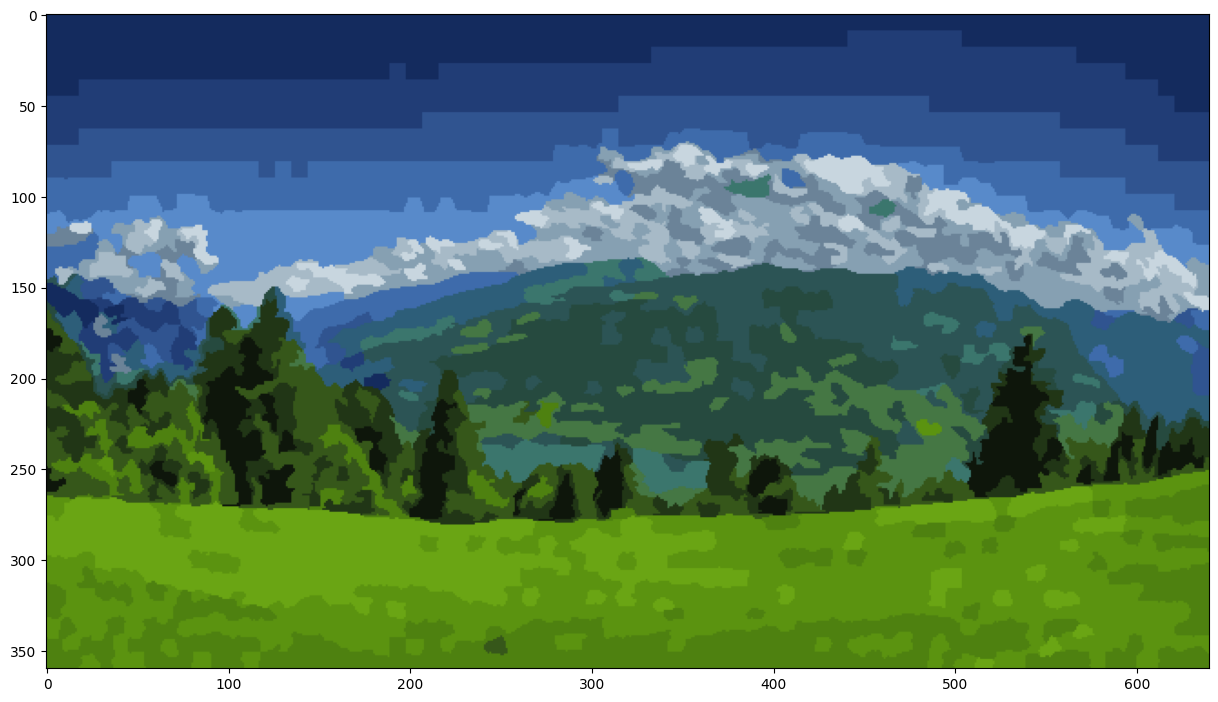

In [9]:
plt.figure(figsize=(15, 15))
plt.imshow(sp_quant)

In [33]:
out = manual_edges(sp_quant)

IndexError: index 360 is out of bounds for axis 0 with size 360

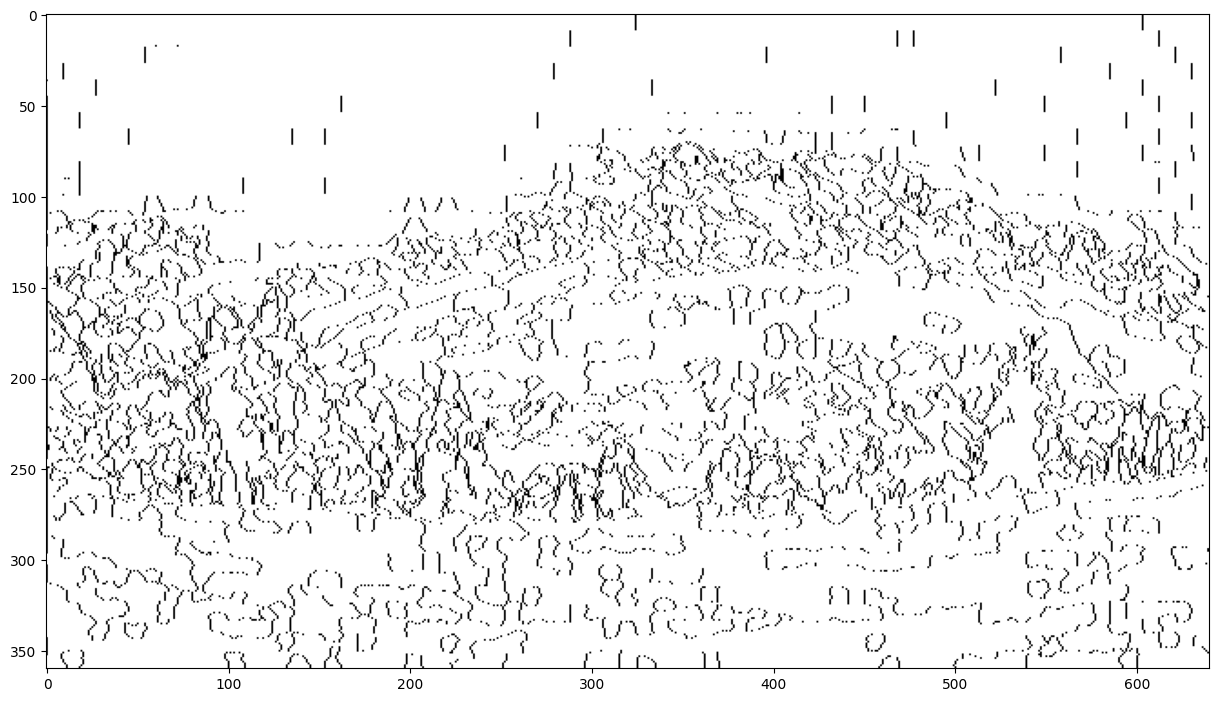

In [31]:
plt.figure(figsize=(15, 15))
plt.imshow(out)

In [ ]:
%watermark